<a href="https://colab.research.google.com/github/Michwynn/Capstone-Team-Air-/blob/CNN/Machine_Learning_with_image_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import warnings # supress warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# machine learning
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# deep learning
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

# feature importance
try:
  import shap
except:
  !pip install shap
  import shap

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks

pd.set_option('display.max_columns', None)

# random seed 
RANDOM_SEED = 44

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks


**import files**

In [2]:
train_df = pd.read_csv("assets/train_df.csv", index_col = 0)
val_df = pd.read_csv("assets/val_df.csv", index_col = 0)
test_df = pd.read_csv("assets/test_df.csv", index_col = 0)

**Split into x_train & y_train, X_val & y_val and X_test & y_test**

In [3]:
outcome_vars = ['price', 'log_price']

X_train = train_df[train_df.columns.difference(outcome_vars)]
y_train = list(train_df.log_price)

X_val = val_df[val_df.columns.difference(outcome_vars)]
y_val = list(val_df.log_price)

X_test = test_df[test_df.columns.difference(outcome_vars)]
y_test = list(test_df.log_price)

**Baseline model - Using Statsmodel for multiple regression**

In [ ]:
# prevent dummy variable trap for linear regression
baseline_vars = ['City of London', 
                 'host_has_profile_pic_f', 
                 'host_identity_verified_f', 
                 'Entire home', 
                 'Entire home/apt (room type)']

# drop in all splitted dfs
train_df_reference = train_df.drop(baseline_vars, axis=1)
val_df_reference = val_df.drop(baseline_vars, axis=1)
test_df_reference = test_df.drop(baseline_vars, axis=1)

X_train_reference = train_df_reference[train_df_reference.columns.difference(outcome_vars)]
y_train_reference = list(train_df.log_price)

X_val_reference = val_df_reference[val_df_reference.columns.difference(outcome_vars)]
y_val_reference = list(val_df_reference.log_price)

X_test_reference = test_df_reference[test_df_reference.columns.difference(outcome_vars)]
y_test_reference = list(test_df_reference.log_price)

# initialise the linear regression model
model = sm.OLS(y_train_reference, X_train_reference).fit()
print(model.summary())
print("The Durbin Watson test statistic is",  durbin_watson(model.resid), "Since this is within the range of 1.5 and 2.5, autocorrelation is not an issue this regression model.")

# prediction
prediction = model.predict(X_val_reference)
rmse_linearreg = mean_squared_error(y_val_reference, prediction)
print("RMSE:", rmse_linearreg)
r_square_linearreg = model.rsquared_adj
print("R^2:", r_square_linearreg)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     538.7
Date:                Wed, 12 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:24:28   Log-Likelihood:                -26214.
No. Observations:               39294   AIC:                         5.269e+04
Df Residuals:                   39164   BIC:                         5.380e+04
Df Model:                         129                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Bark

**LinearRegression - Plotting Predicted Log values vs Actual Log values**

Text(0.5, 1.0, 'LinearRegression (Base Model')

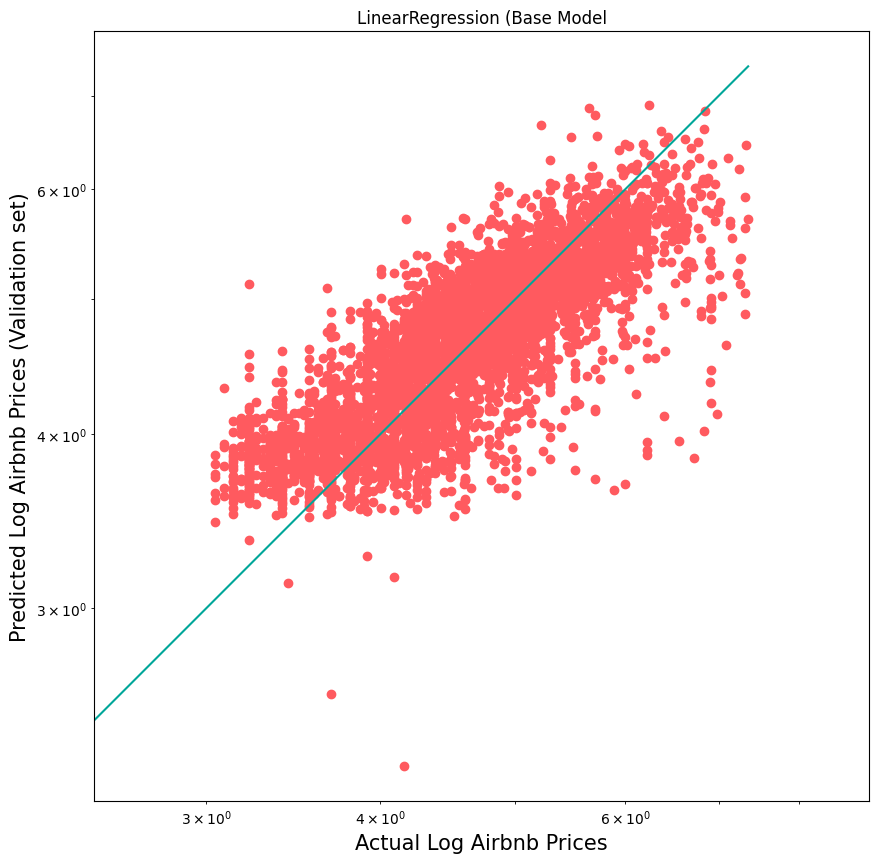

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(y_val_reference, prediction, color = '#FF5A5F')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(prediction), max(y_val_reference))
p2 = min(min(prediction), min(y_val_reference))
plt.plot([p1, p2], [p1, p2], '#00A699')
plt.xlabel('Actual Log Airbnb Prices', fontsize=15)
plt.ylabel('Predicted Log Airbnb Prices (Validation set)', fontsize=15)
plt.axis('equal')
plt.title("LinearRegression (Base Model")


**Adding more Complexity - Other Modelling Techniques - Default parameters on Validation set**

  0%|          | 0/8 [00:00<?, ?it/s]

Ridge(random_state=44) RMSE: 0.48512184911122214
Ridge(random_state=44) R^2: 0.6302483616547541
-------------------------------


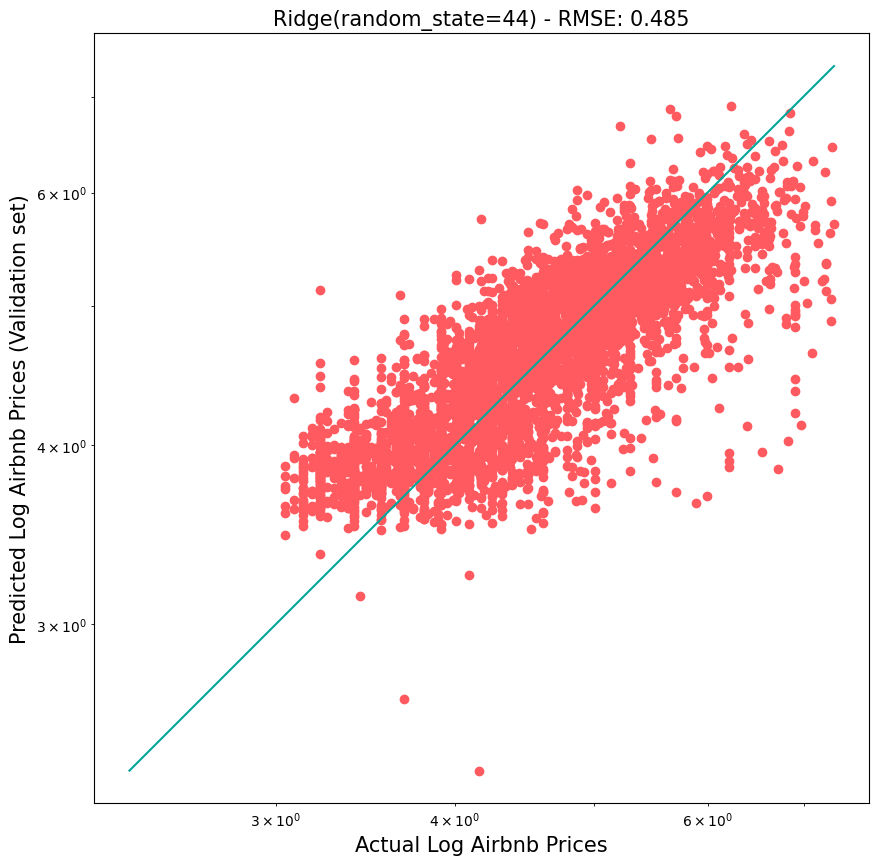

 12%|█▎        | 1/8 [00:01<00:08,  1.17s/it]

DecisionTreeRegressor(random_state=44) RMSE: 0.6399779936027923
DecisionTreeRegressor(random_state=44) R^2: 0.3565148661553561
-------------------------------


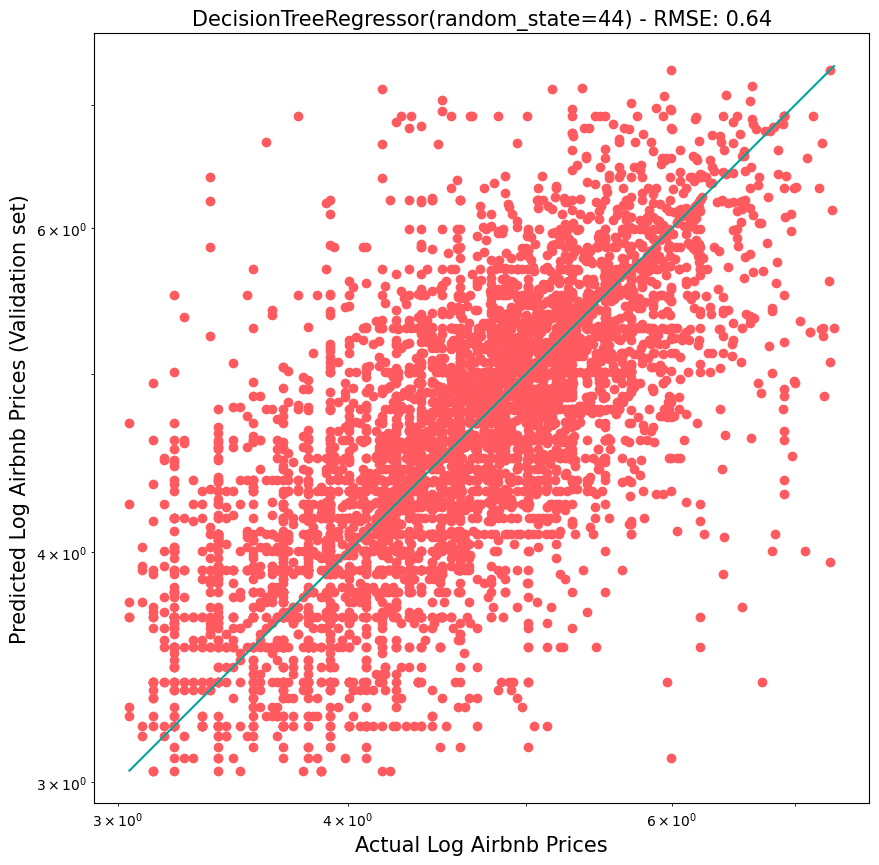

 25%|██▌       | 2/8 [00:02<00:08,  1.43s/it]

BaggingRegressor(random_state=44) RMSE: 0.4709840819061756
BaggingRegressor(random_state=44) R^2: 0.6514854647579253
-------------------------------


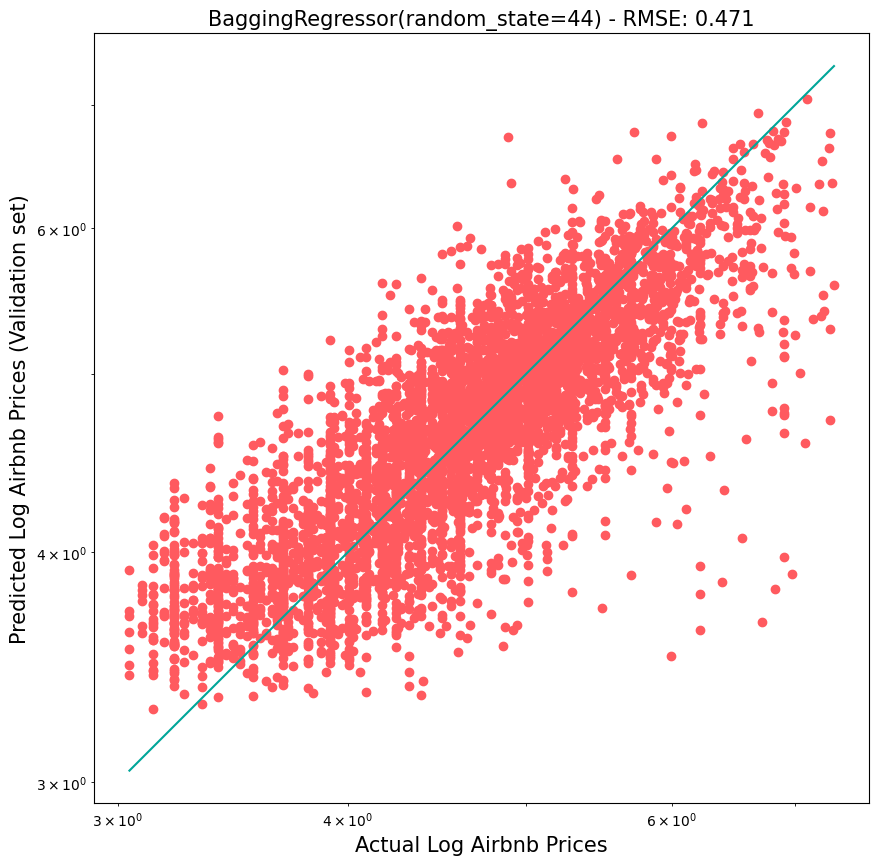

 38%|███▊      | 3/8 [00:09<00:19,  3.95s/it]

RandomForestRegressor(random_state=44) RMSE: 0.44936981588956004
RandomForestRegressor(random_state=44) R^2: 0.6827393335920726
-------------------------------


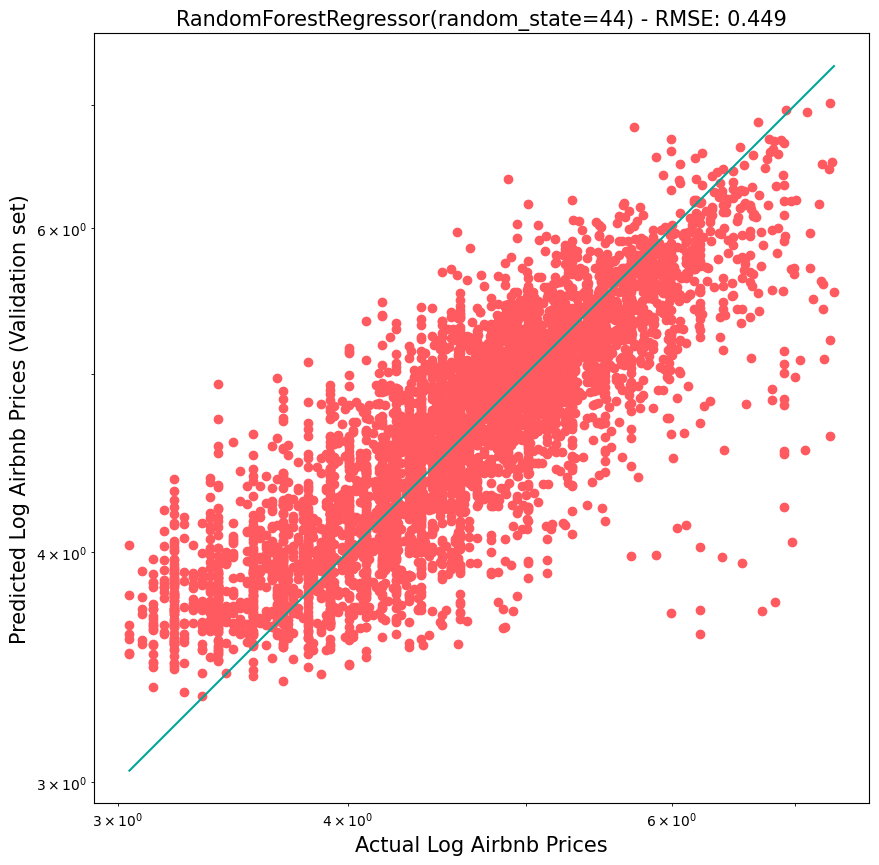

 50%|█████     | 4/8 [01:31<02:18, 34.71s/it]

ExtraTreesRegressor(random_state=44) RMSE: 0.45009671196410705
ExtraTreesRegressor(random_state=44) R^2: 0.6817121081508557
-------------------------------


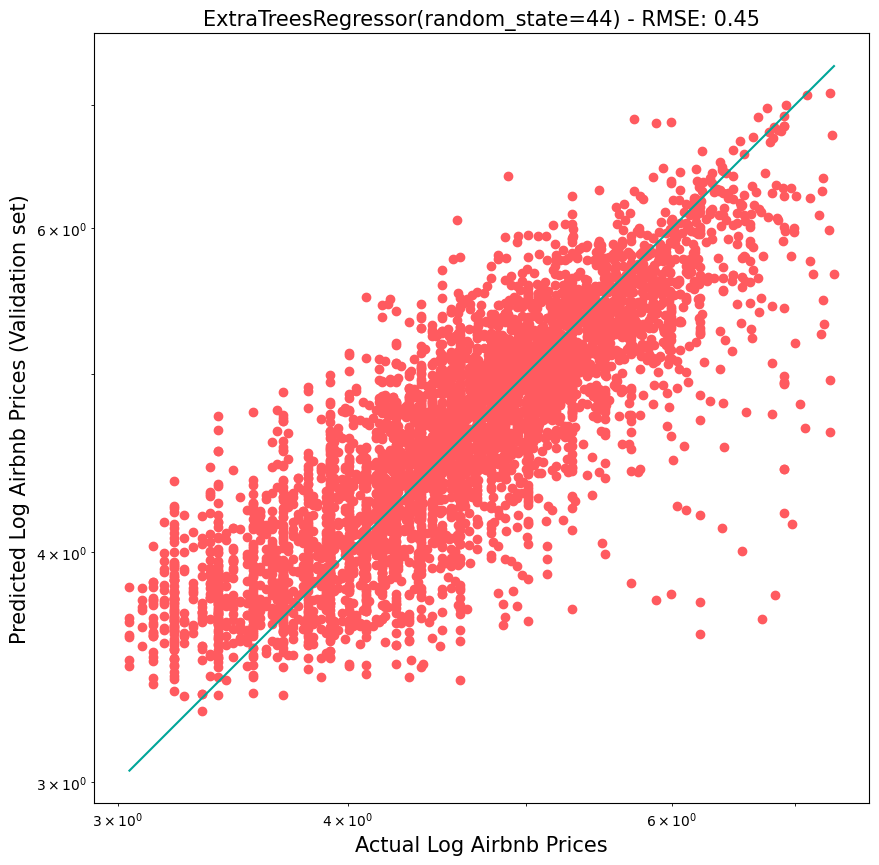

 62%|██████▎   | 5/8 [02:29<02:09, 43.22s/it]

AdaBoostRegressor(random_state=44) RMSE: 0.5728482112848208
AdaBoostRegressor(random_state=44) R^2: 0.4844300937436298
-------------------------------


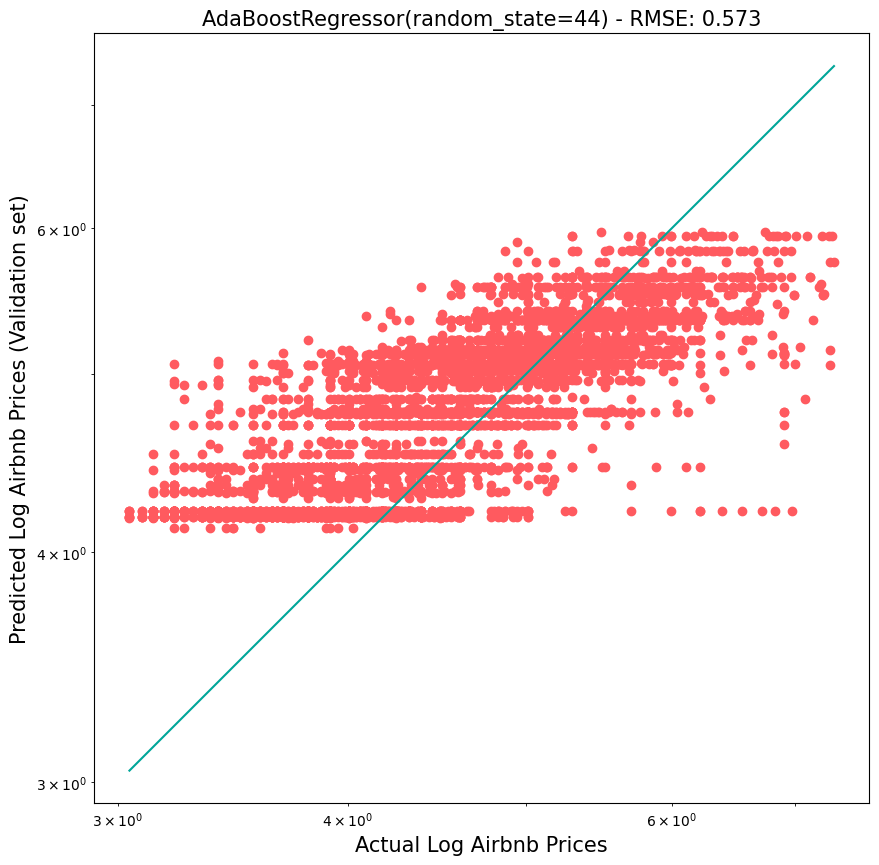

 75%|███████▌  | 6/8 [02:37<01:01, 30.95s/it]

LGBMRegressor(random_state=44) RMSE: 0.4465205718309005
LGBMRegressor(random_state=44) R^2: 0.6867497822911357
-------------------------------


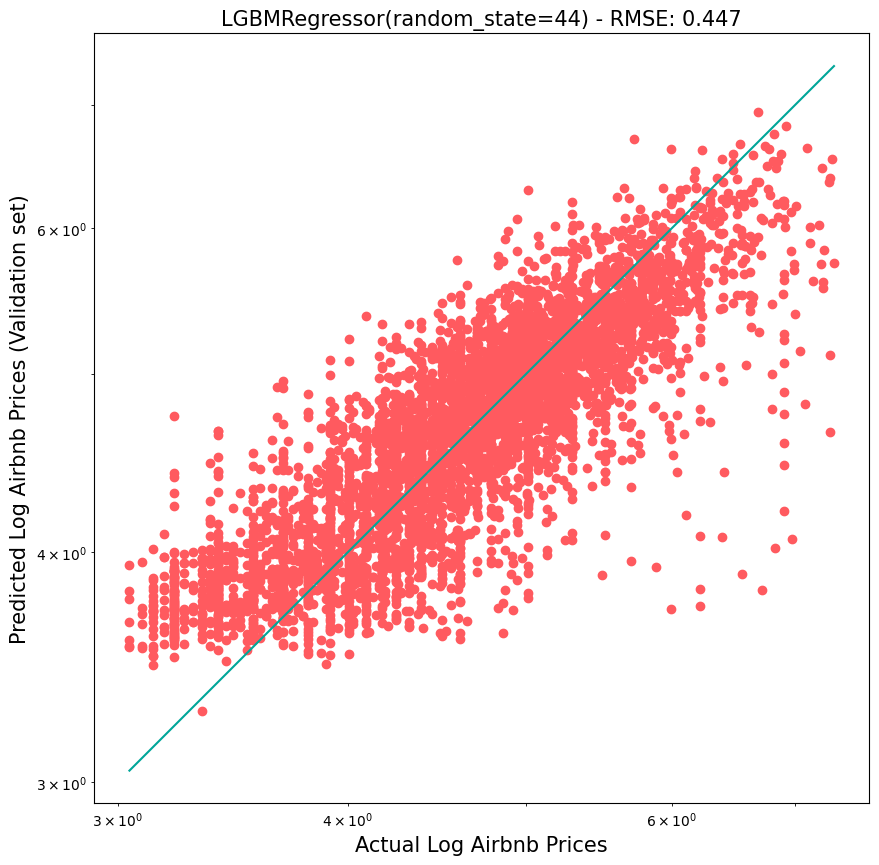

 88%|████████▊ | 7/8 [02:41<00:22, 22.28s/it]

KNeighborsRegressor() RMSE: 0.5062106324157759
KNeighborsRegressor() R^2: 0.5974026029871018
-------------------------------


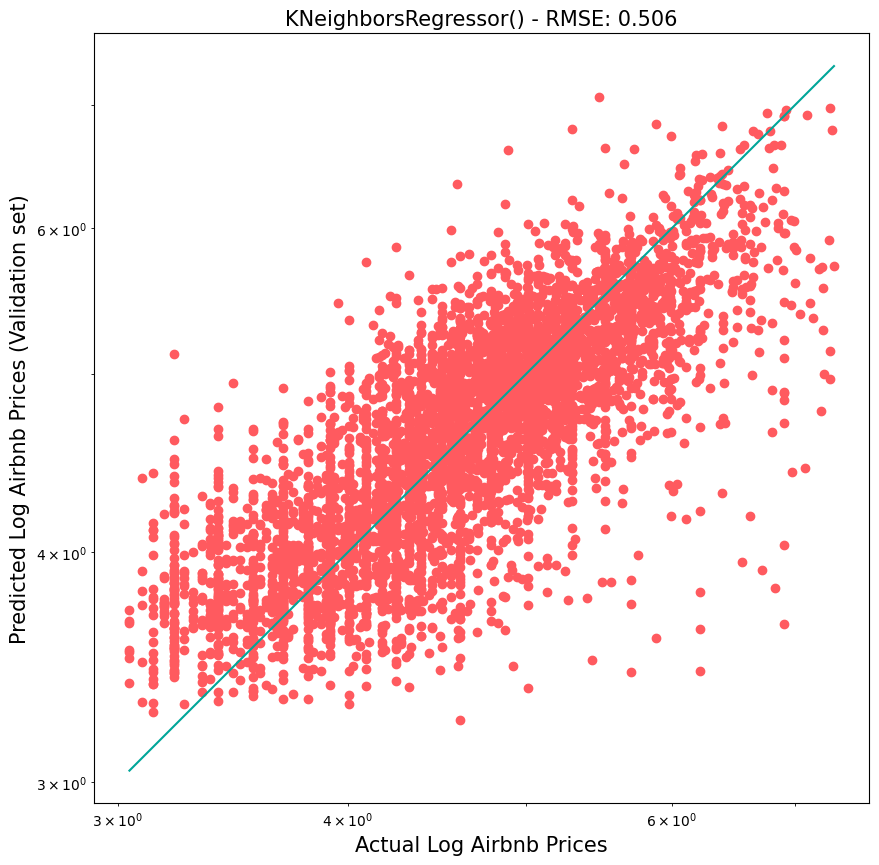

100%|██████████| 8/8 [02:44<00:00, 20.59s/it]


In [ ]:
model_names = ['RidgeRegression',
               'DecisionTreeRegressor',
               'BaggingRegressor',
               'RandomForestRegressor',
               'ExtraTreesRegressor',
               'AdaBoostRegressor',
               'LGBMRegressor',
               'KNeighborsRegressor']


model_list =  [Ridge(random_state = RANDOM_SEED),
               DecisionTreeRegressor(random_state = RANDOM_SEED), 
               BaggingRegressor(random_state = RANDOM_SEED), 
               RandomForestRegressor(random_state = RANDOM_SEED),
               ExtraTreesRegressor(random_state = RANDOM_SEED),
               AdaBoostRegressor(random_state = RANDOM_SEED),
               lightgbm.LGBMRegressor(random_state = RANDOM_SEED),
               KNeighborsRegressor(n_neighbors=5)]
              
rmse_list = []
r_square_list = []

for model in tqdm(model_list):
  
  model.fit(X_train, y_train)
  prediction = model.predict(X_val)

  # RMSE Caculation and append to list
  rmse_list.append(np.sqrt(mean_squared_error(y_val, prediction)))
  print(str(model), "RMSE:", np.sqrt(mean_squared_error(y_val, prediction)))

  # R-square Caculation and append to list
  r_square = r2_score(y_val, prediction)
  r_square_list.append(r_square)
  print(str(model), "R^2:", r_square)
  print("-------------------------------")


  plt.figure(figsize=(10,10))
  plt.scatter(y_val, prediction, color = '#FF5A5F')
  plt.yscale('log')
  plt.xscale('log')

  p1 = max(max(prediction), max(y_val))
  p2 = min(min(prediction), min(y_val))
  plt.plot([p1, p2], [p1, p2], '#00A699')
  plt.xlabel('Actual Log Airbnb Prices', fontsize=15)
  plt.ylabel('Predicted Log Airbnb Prices (Validation set)', fontsize=15)
  plt.axis('equal')
  plt.title(str(model) + " - RMSE: " + str(np.round(np.sqrt(mean_squared_error(y_val, prediction)), 3)), fontsize=15)
  plt.show()

In [ ]:
# add linear regression result to both lists
model_names.insert(0, "LinearRegression (Base Model)")
rmse_list.insert(0, rmse_linearreg)
r_square_list.insert(0, r_square_linearreg)

In [ ]:
# plotting results of classifiers on default hyperparameters
df_plot = pd.DataFrame()
df_plot['Model Names'] = model_names
df_plot['RMSE'] = rmse_list
df_plot['R-square'] = r_square_list
df_plot

Model Names      RMSE  R-square
0  LinearRegression (Base Model)  0.274331  0.638390
1                RidgeRegression  0.485122  0.630248
2          DecisionTreeRegressor  0.639978  0.356515
3               BaggingRegressor  0.470984  0.651485
4          RandomForestRegressor  0.449370  0.682739
5            ExtraTreesRegressor  0.450097  0.681712
6              AdaBoostRegressor  0.572848  0.484430
7                  LGBMRegressor  0.446521  0.686750
8            KNeighborsRegressor  0.506211  0.597403

NameError: ignored

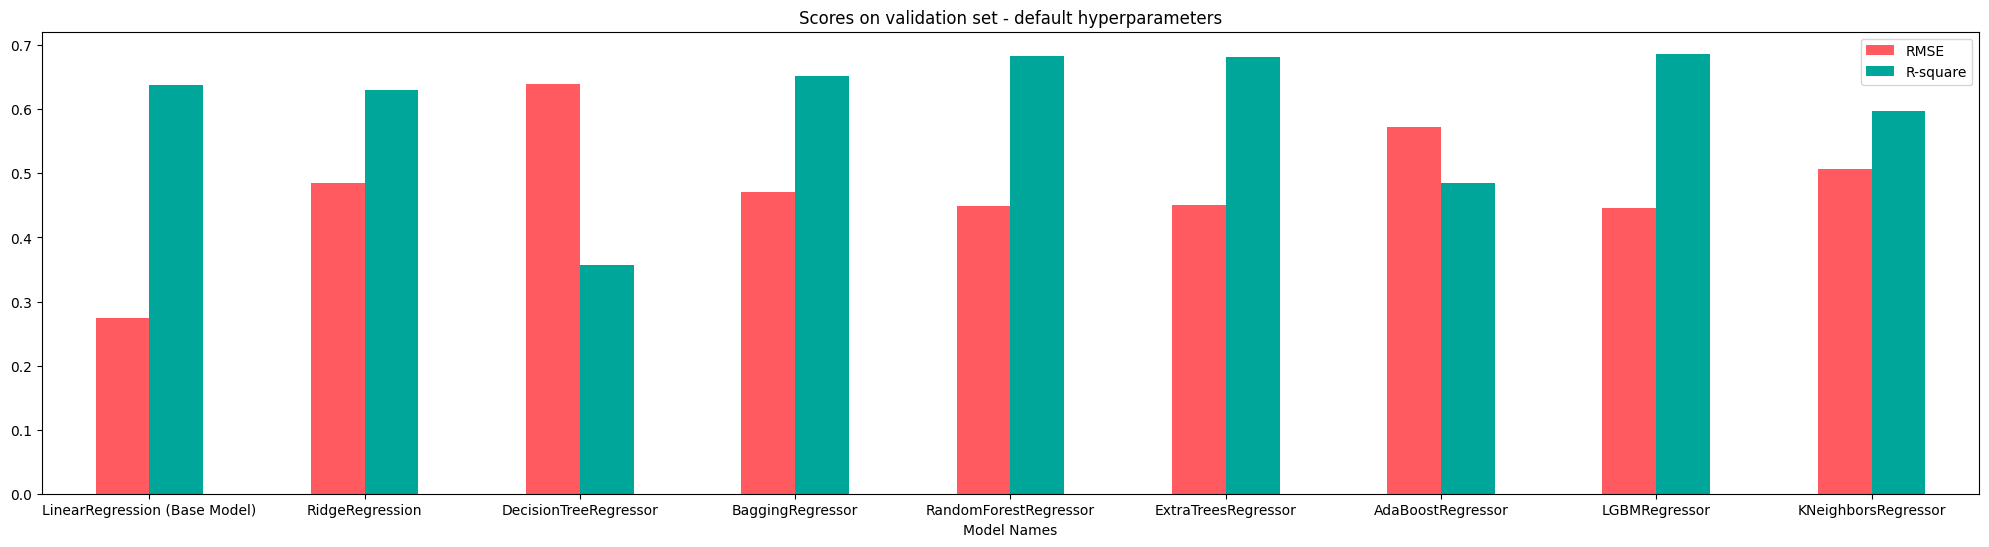

In [ ]:
# plot the results
df_plot = df_plot.set_index('Model Names') # set index for x axis
df_plot[['RMSE', 'R-square']].plot(kind='bar', figsize=(25,6), color=['#FF5A5F', '#00A699'])
plt.xticks(rotation = 0)
plt.title("Scores on validation set - default hyperparameters")
matplotlib.rcParams.update({'font.size': 22})

**Hyperparameter Tuning on train set**

In [ ]:
# Helper function: Source - https://www.davidsbatista.net/blog/2018/02/23/model_optimization/

class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

We decided we pick the top 4 emsemble techniques that have the lowest RMSE to compare against the baseline model. Hence, hyperparameter tuning was performed on the following 4 algorithms. 

In [ ]:
%%time
model_names = ['BaggingRegressor',
               'RandomForestRegressor',
               'ExtraTreesRegressor',
               'LGBMRegressor']

model_list =  [BaggingRegressor(random_state = RANDOM_SEED), 
               RandomForestRegressor(random_state = RANDOM_SEED),
               ExtraTreesRegressor(random_state = RANDOM_SEED),
               lightgbm.LGBMRegressor(random_state = RANDOM_SEED)]  

# convert the two lists into a dictionary
dict_model = {model_names[i]: model_list[i] for i in range(len(model_list))}

# the optimisation parameters for each of the above models
params = {'BaggingRegressor': {'n_estimators': [5, 15 , 20, 50, 200]},
          
          'RandomForestRegressor': {'n_estimators': [5, 15 , 20, 50, 200],
                                    'max_features': ['auto', 'sqrt'],
                                    'max_depth': [None, 1, 3, 5, 12]},
          
          'ExtraTreesRegressor': {'n_estimators': [5, 15, 20, 50, 200],
                                  'max_features': ['auto', 'sqrt'],
                                  'max_depth': [None, 1, 3, 5, 12]},
          
          'LGBMRegressor': {'n_estimators': [5, 15, 20, 50, 200],
                            'num_leaves ': [31, 10, 20, 50, 60, 100],
                            'max_depth': [None, 1, 3, 5, 12]}}

helper = EstimatorSelectionHelper(dict_model, params)
helper.fit(X_train, y_train, scoring = 'neg_mean_squared_error', n_jobs=2)

Running GridSearchCV for BaggingRegressor.
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Running GridSearchCV for RandomForestRegressor.
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Running GridSearchCV for ExtraTreesRegressor.
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Running GridSearchCV for LGBMRegressor.
Fitting 3 folds for each of 150 candidates, totalling 450 fits
CPU times: user 17.1 s, sys: 2.2 s, total: 19.3 s
Wall time: 34min 31s


In [ ]:
df_scores = helper.score_summary(sort_by='mean_score')
df_scores

BaggingRegressor
RandomForestRegressor
ExtraTreesRegressor
LGBMRegressor


estimator min_score mean_score max_score std_score  \
130          LGBMRegressor -0.195451  -0.191898 -0.187067   0.00354   
134          LGBMRegressor -0.195451  -0.191898 -0.187067   0.00354   
133          LGBMRegressor -0.195451  -0.191898 -0.187067   0.00354   
129          LGBMRegressor -0.195451  -0.191898 -0.187067   0.00354   
132          LGBMRegressor -0.195451  -0.191898 -0.187067   0.00354   
..                     ...       ...        ...       ...       ...   
71     ExtraTreesRegressor -0.523321  -0.493305 -0.469836  0.022321   
23   RandomForestRegressor -0.504672  -0.495133 -0.484199  0.008416   
21   RandomForestRegressor -0.523027  -0.500762 -0.486217  0.015988   
22   RandomForestRegressor -0.527363  -0.504413 -0.491385  0.016278   
20   RandomForestRegressor -0.563224  -0.544434 -0.515182  0.020962   

    n_estimators max_depth max_features num_leaves   
130          200      None          NaN          10  
134          200      None          NaN         100  
133          200      None          NaN          60  
129          200      None          NaN          31  
132          200      None          NaN          50  
..           ...       ...          ...         ...  
71            15         1         sqrt         NaN  
23            50         1         sqrt         NaN  
21            15         1         sqrt         NaN  
22            20         1         sqrt         NaN  
20             5         1         sqrt         NaN  

[255 rows x 9 columns]

In [ ]:
for estima in np.unique(df_scores.estimator):
  df_i = df_scores[df_scores['estimator'] == estima].head(1)
  print(df_i)

          estimator min_score mean_score max_score std_score n_estimators  \
4  BaggingRegressor  -0.20253   -0.19827  -0.19142  0.004892          200   

  max_depth max_features num_leaves   
4       NaN          NaN         NaN  
              estimator min_score mean_score max_score std_score n_estimators  \
59  ExtraTreesRegressor -0.206856   -0.20305 -0.196806  0.004451          200   

   max_depth max_features num_leaves   
59      None         auto         NaN  
         estimator min_score mean_score max_score std_score n_estimators  \
130  LGBMRegressor -0.195451  -0.191898 -0.187067   0.00354          200   

    max_depth max_features num_leaves   
130      None          NaN          10  
                estimator min_score mean_score max_score std_score  \
14  RandomForestRegressor -0.201435  -0.197962 -0.191874  0.004319   

   n_estimators max_depth max_features num_leaves   
14          200      None         sqrt         NaN  


**Tuned models on Validation set**

  0%|          | 0/4 [00:00<?, ?it/s]

BaggingRegressor(n_estimators=200, random_state=44) RMSE: 0.44838985551219523
BaggingRegressor(n_estimators=200, random_state=44) R^2: 0.6841215531878253
-------------------------------


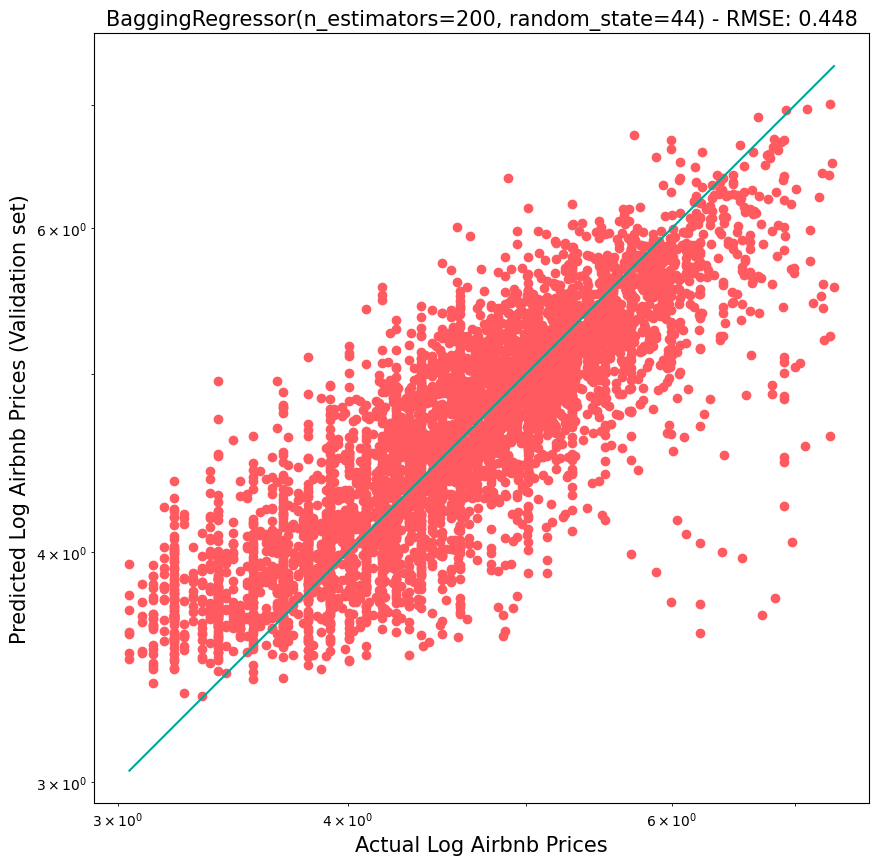

 25%|██▌       | 1/4 [02:25<07:15, 145.27s/it]

RandomForestRegressor(max_features='sqrt', n_estimators=200, random_state=44) RMSE: 0.445590821505569
RandomForestRegressor(max_features='sqrt', n_estimators=200, random_state=44) R^2: 0.6880529306513501
-------------------------------


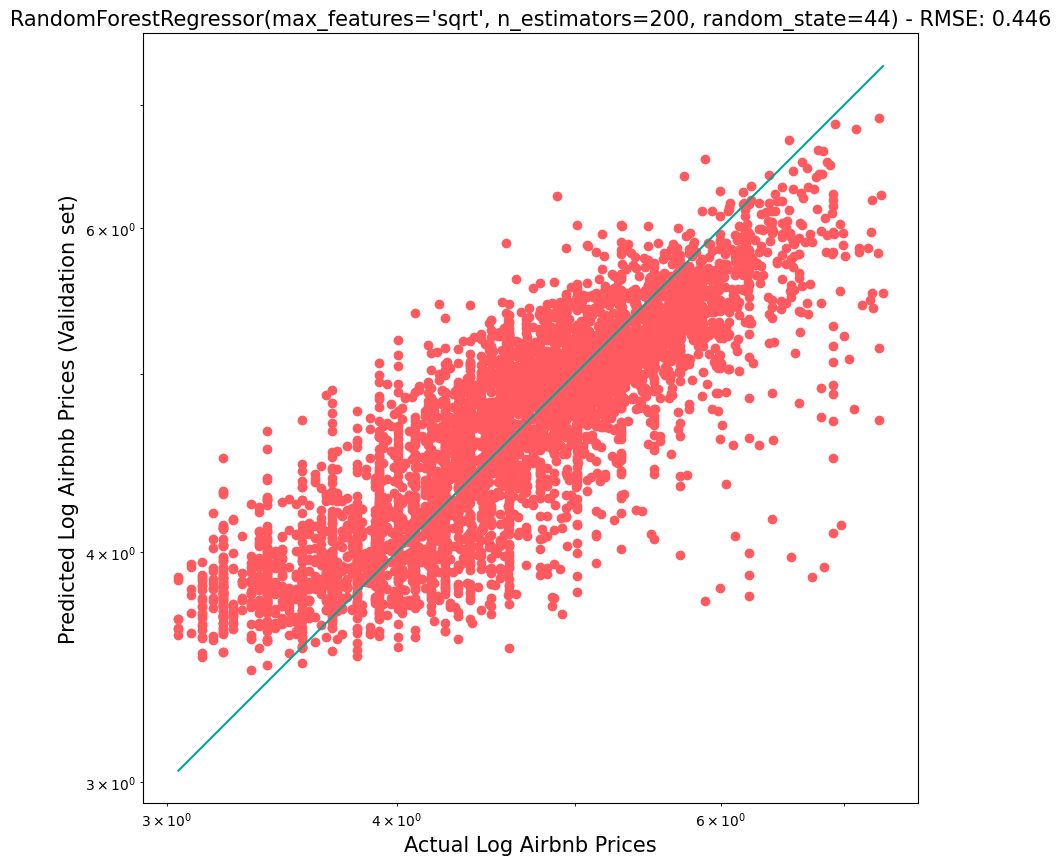

 50%|█████     | 2/4 [02:55<02:34, 77.40s/it] 

ExtraTreesRegressor(max_features='sqrt', n_estimators=200, random_state=44) RMSE: 0.44988968814409125
ExtraTreesRegressor(max_features='sqrt', n_estimators=200, random_state=44) R^2: 0.6820048364448725
-------------------------------


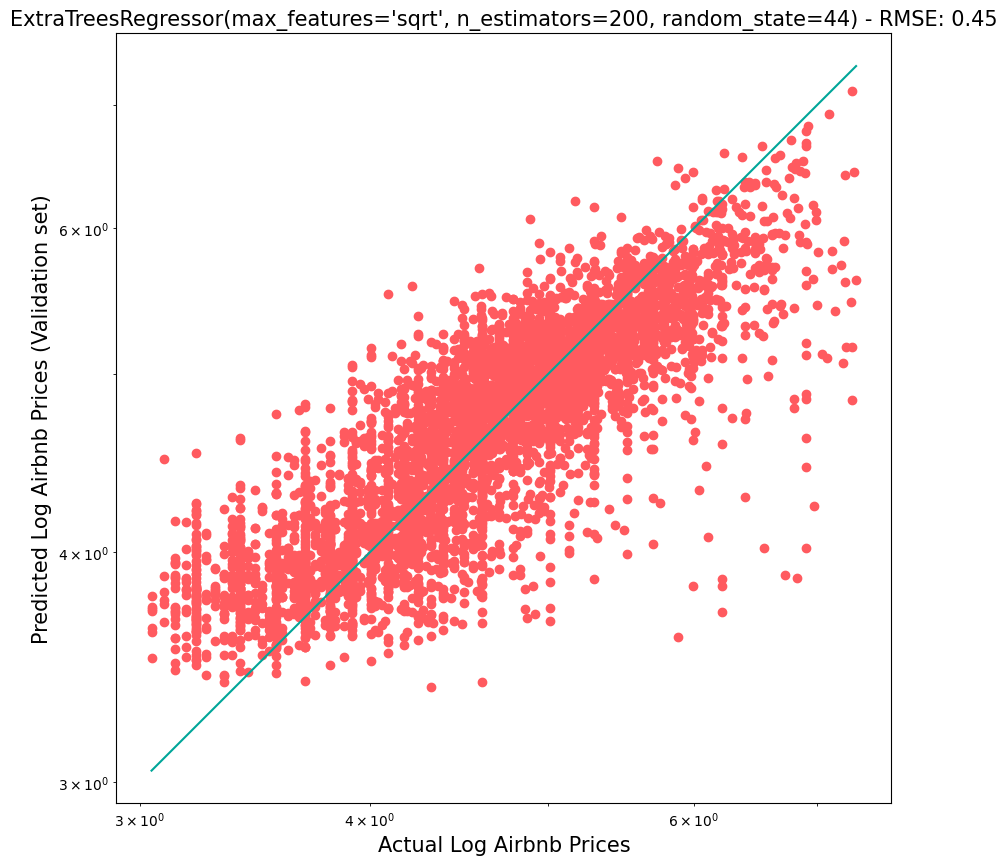

 75%|███████▌  | 3/4 [03:26<00:56, 56.47s/it]

LGBMRegressor(max_depth=12, n_estimators=200, num_leaves=100, random_state=44) RMSE: 0.43903019974583773
LGBMRegressor(max_depth=12, n_estimators=200, num_leaves=100, random_state=44) R^2: 0.6971711637928932
-------------------------------


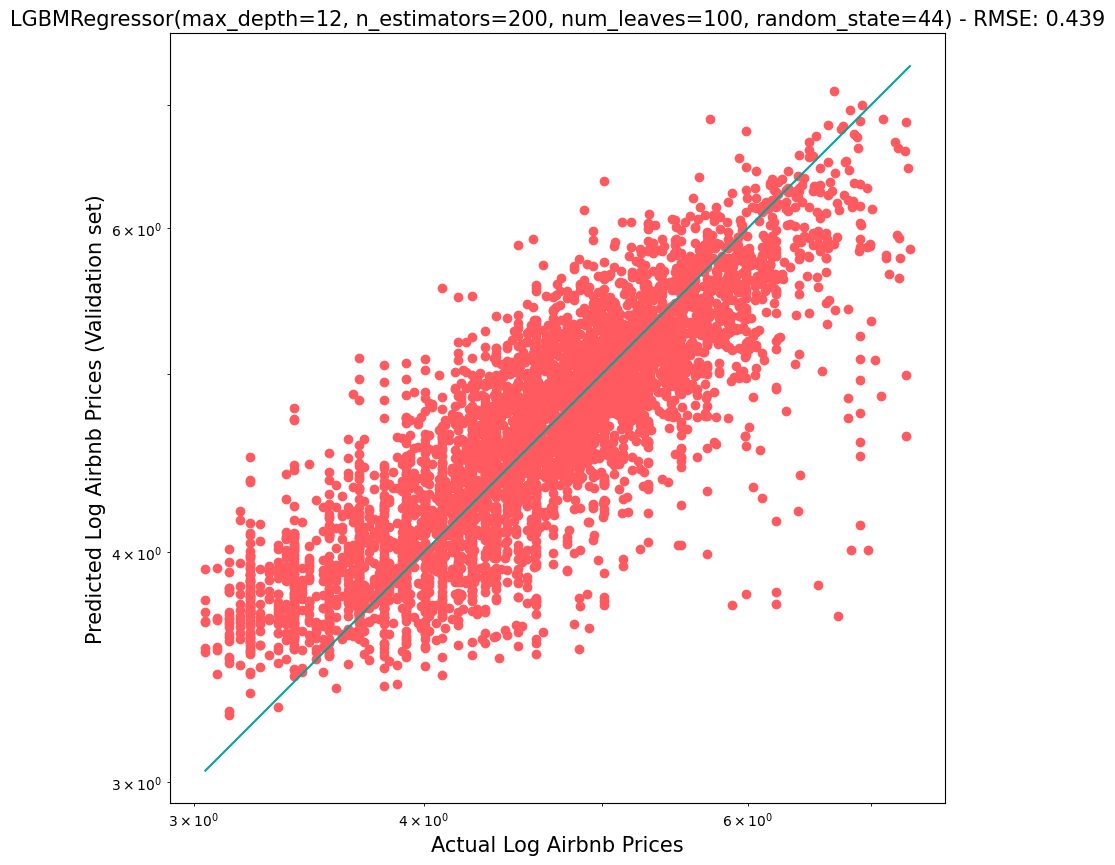

100%|██████████| 4/4 [03:29<00:00, 52.32s/it]


In [ ]:
# best hyperparameters for each model
tuned_model_list =  [BaggingRegressor(n_estimators = 200, random_state = RANDOM_SEED), 
                     RandomForestRegressor(n_estimators = 200, max_features = 'sqrt', max_depth = None, random_state = RANDOM_SEED),
                     ExtraTreesRegressor(n_estimators = 200, max_features = 'sqrt', random_state = RANDOM_SEED),
                     lightgbm.LGBMRegressor(n_estimators = 200, max_depth = 12, num_leaves = 100, random_state = RANDOM_SEED)]

model_names = ['BaggingRegressor',
               'RandomForestRegressor',
               'ExtraTreesRegressor',
               'LGBMRegressor']

tuned_rmse_list = []
tuned_r_square_list = []

for model in tqdm(tuned_model_list):
  
  model.fit(X_train, y_train)
  prediction = model.predict(X_val)

  # RMSE Caculation and append to list
  tuned_rmse_list.append(np.sqrt(mean_squared_error(y_val, prediction)))
  print(str(model), "RMSE:", np.sqrt(mean_squared_error(y_val, prediction)))

  # R-square Caculation and append to list
  r_square = r2_score(y_val, prediction)
  tuned_r_square_list.append(r_square)
  print(str(model), "R^2:", r_square)
  print("-------------------------------")


  plt.figure(figsize=(10,10))
  plt.scatter(y_val, prediction, color = '#FF5A5F')
  plt.yscale('log')
  plt.xscale('log')

  p1 = max(max(prediction), max(y_val))
  p2 = min(min(prediction), min(y_val))
  plt.plot([p1, p2], [p1, p2], '#00A699')
  plt.xlabel('Actual Log Airbnb Prices', fontsize=15)
  plt.ylabel('Predicted Log Airbnb Prices (Validation set)', fontsize=15)
  plt.axis('equal')
  plt.title(str(model) + " - RMSE: " + str(np.round(np.sqrt(mean_squared_error(y_val, prediction)), 3)), fontsize=15)
  plt.show()

In [ ]:
# plotting results of classifiers on default hyperparameters

model_names = ['BaggingRegressor',
               'RandomForestRegressor',
               'ExtraTreesRegressor',
               'LGBMRegressor']

               
df_plot = pd.DataFrame()
df_plot['Model Names'] = model_names
df_plot['RMSE (Tuned)'] = tuned_rmse_list
df_plot['R-square (Tuned)'] = tuned_r_square_list
df_plot = df_plot.set_index('Model Names')
df_plot.reset_index()

Model Names  RMSE (Tuned)  R-square (Tuned)
0       BaggingRegressor      0.448390          0.684122
1  RandomForestRegressor      0.445591          0.688053
2    ExtraTreesRegressor      0.449890          0.682005
3          LGBMRegressor      0.439030          0.697171

**Out of Sample (Test set results) - Baseline Model and 4 tuned models**

In [ ]:
# initialise the linear regression model
model = sm.OLS(y_train_reference, X_train_reference).fit()
print(model.summary())
print("The Durbin Watson test statistic is",  durbin_watson(model.resid), "Since this is within the range of 1.5 and 2.5, autocorrelation is not an issue this regression model.")

# prediction
prediction = model.predict(X_test_reference)
rmse_linearreg = mean_squared_error(y_test_reference, prediction)
print("RMSE:", rmse_linearreg)
r_square_linearreg = model.rsquared_adj
print("R^2:", r_square_linearreg)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     538.7
Date:                Wed, 12 Apr 2023   Prob (F-statistic):               0.00
Time:                        16:17:01   Log-Likelihood:                -26214.
No. Observations:               39294   AIC:                         5.269e+04
Df Residuals:                   39164   BIC:                         5.380e+04
Df Model:                         129                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Bark

  0%|          | 0/4 [00:00<?, ?it/s]

BaggingRegressor(n_estimators=200, random_state=44) RMSE: 0.42938660443464705
BaggingRegressor(n_estimators=200, random_state=44) R^2: 0.7021487134207978
-------------------------------


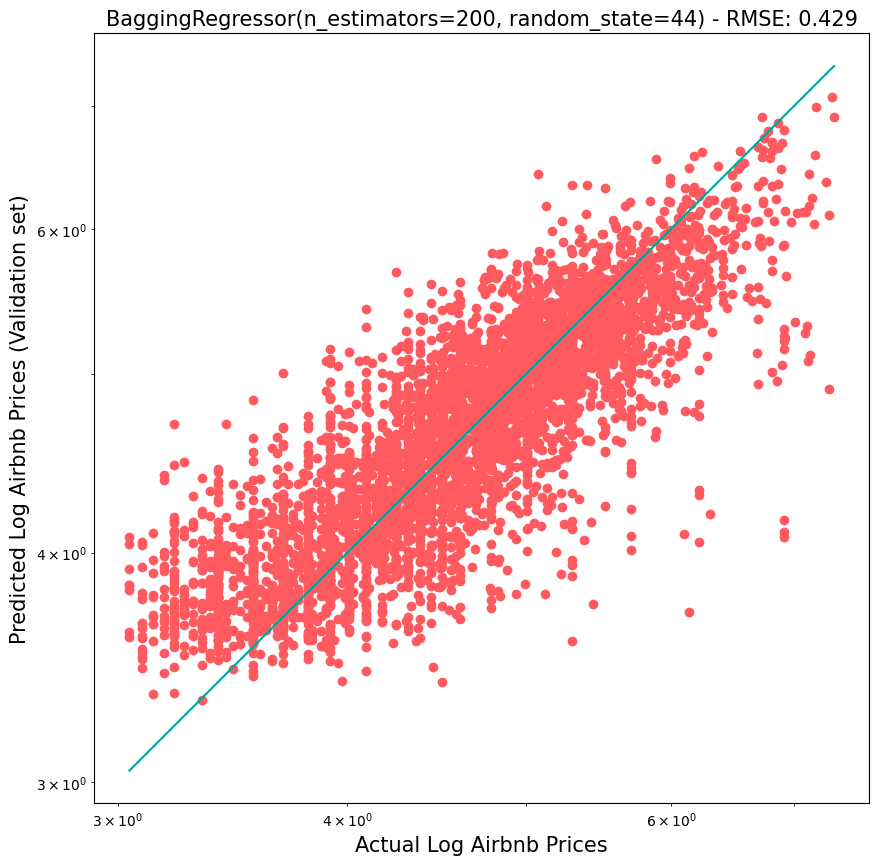

 25%|██▌       | 1/4 [02:24<07:13, 144.34s/it]

RandomForestRegressor(max_features='sqrt', n_estimators=200, random_state=44) RMSE: 0.42920850810216676
RandomForestRegressor(max_features='sqrt', n_estimators=200, random_state=44) R^2: 0.7023957412518825
-------------------------------


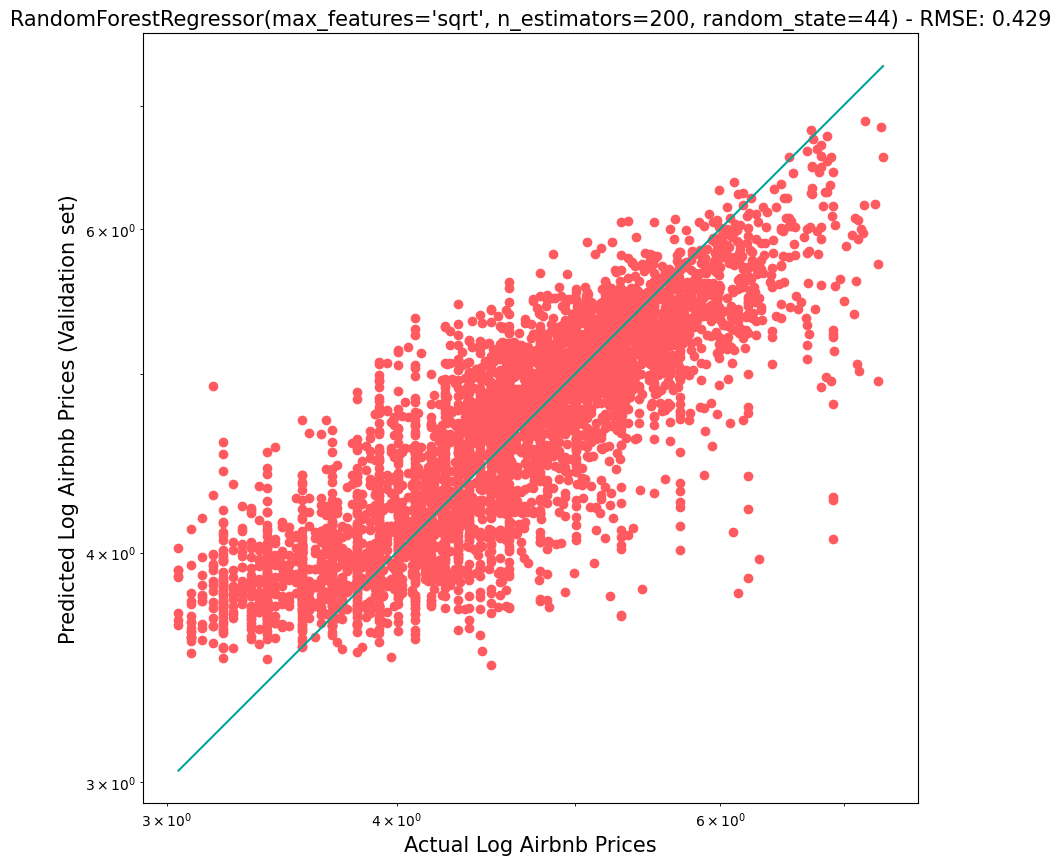

 50%|█████     | 2/4 [02:53<02:32, 76.47s/it] 

ExtraTreesRegressor(max_features='sqrt', n_estimators=200, random_state=44) RMSE: 0.4366030761066903
ExtraTreesRegressor(max_features='sqrt', n_estimators=200, random_state=44) R^2: 0.6920529276803711
-------------------------------


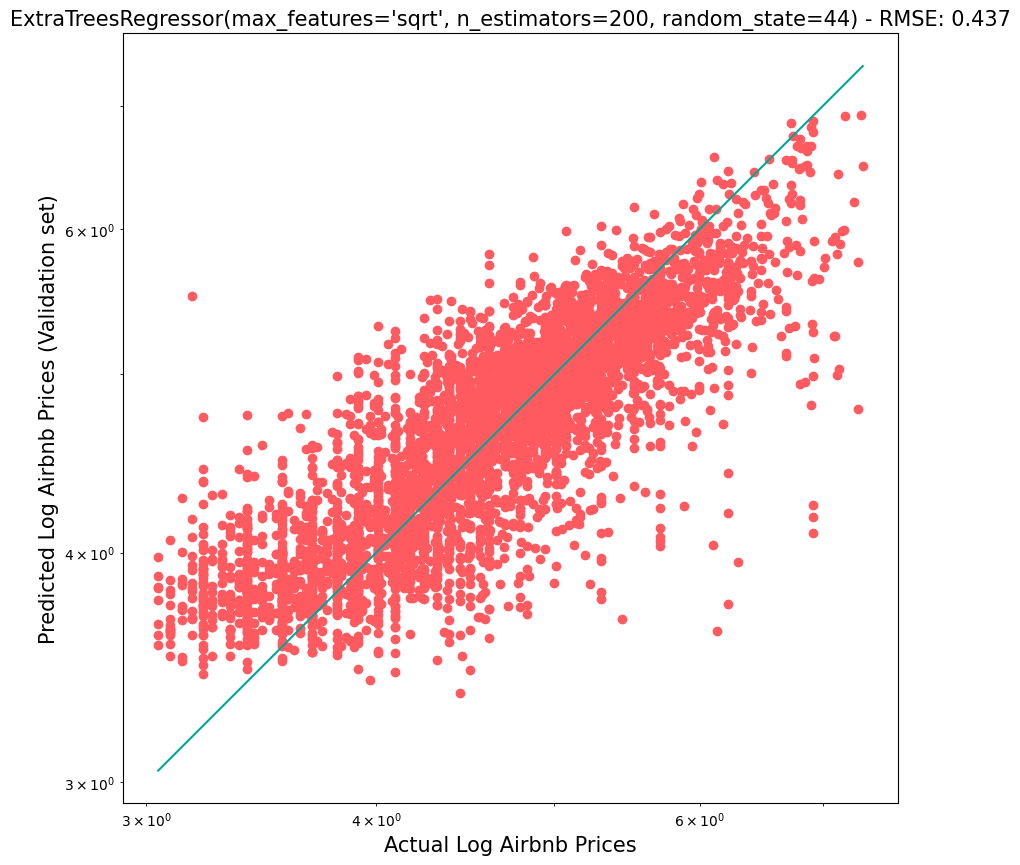

 75%|███████▌  | 3/4 [03:25<00:56, 56.04s/it]

LGBMRegressor(max_depth=12, n_estimators=200, num_leaves=100, random_state=44) RMSE: 0.41959878212324503
LGBMRegressor(max_depth=12, n_estimators=200, num_leaves=100, random_state=44) R^2: 0.7155729250023928
-------------------------------


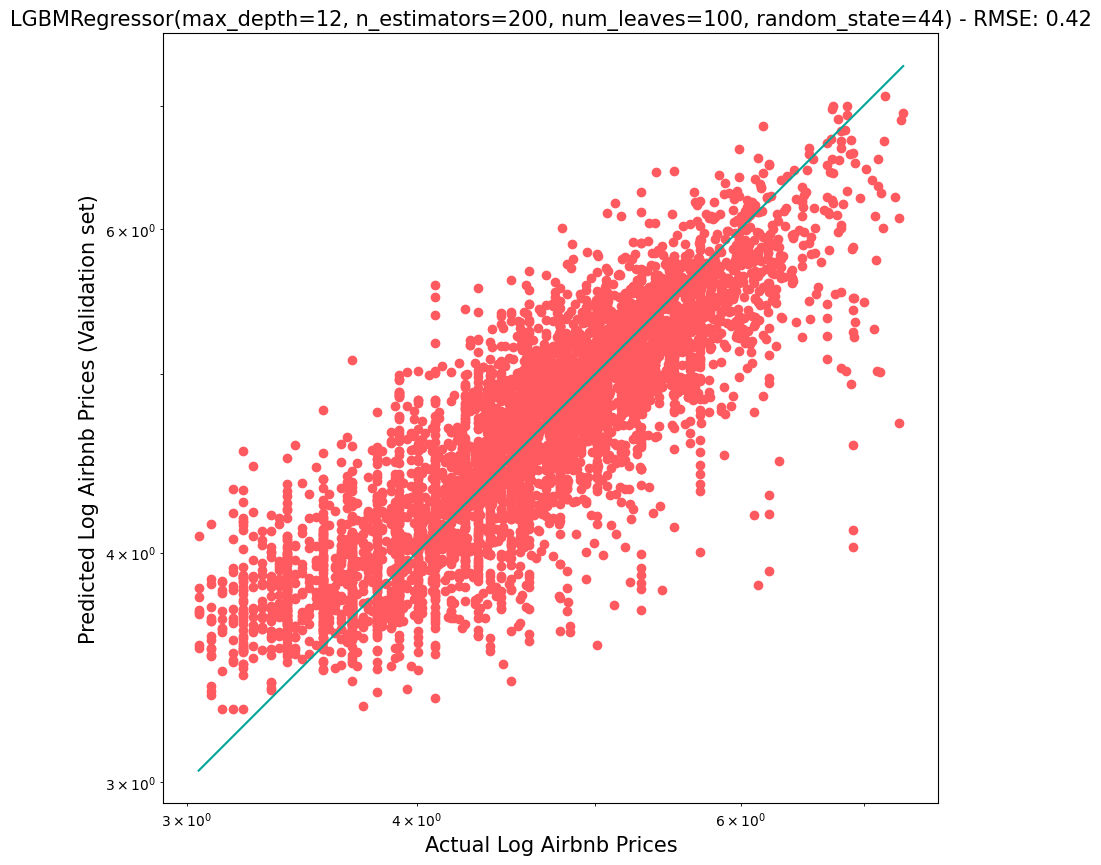

100%|██████████| 4/4 [03:30<00:00, 52.61s/it]


In [ ]:
test_rmse_list = []
test_r_square_list = []

for model in tqdm(tuned_model_list):
  
  model.fit(X_train, y_train)
  prediction = model.predict(X_test)

  # RMSE Caculation and append to list
  test_rmse_list.append(np.sqrt(mean_squared_error(y_test, prediction)))
  print(str(model), "RMSE:", np.sqrt(mean_squared_error(y_test, prediction)))

  # R-square Caculation and append to list
  r_square = r2_score(y_test, prediction)
  test_r_square_list.append(r_square)
  print(str(model), "R^2:", r_square)
  print("-------------------------------")


  plt.figure(figsize=(10,10))
  plt.scatter(y_test, prediction, color = '#FF5A5F')
  plt.yscale('log')
  plt.xscale('log')

  p1 = max(max(prediction), max(y_test))
  p2 = min(min(prediction), min(y_test))
  plt.plot([p1, p2], [p1, p2], '#00A699')
  plt.xlabel('Actual Log Airbnb Prices', fontsize=15)
  plt.ylabel('Predicted Log Airbnb Prices (Validation set)', fontsize=15)
  plt.axis('equal')
  plt.title(str(model) + " - RMSE: " + str(np.round(np.sqrt(mean_squared_error(y_test, prediction)), 3)), fontsize=15)
  plt.show()

In [ ]:
test_model_names = ['BaggingRegressor',
                    'RandomForestRegressor',
                    'ExtraTreesRegressor',
                    'LGBMRegressor']
                    
                    
# add linear regression result to both lists
test_model_names.insert(0, "LinearRegression (Base Model)")
test_rmse_list.insert(0, rmse_linearreg)
test_r_square_list.insert(0, r_square_linearreg)
# plotting results of classifiers on default hyperparameters
df_plot = pd.DataFrame()
               
df_plot['Model Names'] = test_model_names
df_plot['RMSE'] = test_rmse_list
df_plot['R-square'] = test_r_square_list
df_plot = df_plot.set_index('Model Names')
df_plot.reset_index()

Model Names      RMSE  R-square
0  LinearRegression (Base Model)  0.219991  0.638390
1               BaggingRegressor  0.429387  0.702149
2          RandomForestRegressor  0.429209  0.702396
3            ExtraTreesRegressor  0.436603  0.692053
4                  LGBMRegressor  0.419599  0.715573

**Feature Importance for LGBMRegressor using Sharpely values**

**Row = 50**

In [ ]:
%%time
shap.initjs()

i = 50
model = lightgbm.LGBMRegressor(n_estimators = 200, max_depth = 12, num_leaves = 100, random_state = RANDOM_SEED).fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.force_plot(explainer.expected_value, 
                shap_values[i], 
                features = X_train.iloc[i], 
                feature_names = X_train.columns,
                plot_cmap = ['#00A699','#FF5A5F'])

CPU times: user 9min 37s, sys: 684 ms, total: 9min 38s
Wall time: 6min 14s


**row = 500**

In [ ]:
%%time
shap.initjs()

i = 500
model = lightgbm.LGBMRegressor(n_estimators = 200, max_depth = 12, num_leaves = 100, random_state = RANDOM_SEED).fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.force_plot(explainer.expected_value, 
                shap_values[i], 
                features = X_train.iloc[i], 
                feature_names = X_train.columns,
                plot_cmap = ['#00A699','#FF5A5F'])

CPU times: user 9min 32s, sys: 664 ms, total: 9min 33s
Wall time: 5min 42s


**row = 1500**

In [ ]:
%%time
shap.initjs()

i = 1500
model = lightgbm.LGBMRegressor(n_estimators = 200, max_depth = 12, num_leaves = 100, random_state = RANDOM_SEED).fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.force_plot(explainer.expected_value, 
                shap_values[i], 
                features = X_train.iloc[i], 
                feature_names = X_train.columns,
                plot_cmap = ['#00A699','#FF5A5F'])

CPU times: user 9min 34s, sys: 588 ms, total: 9min 35s
Wall time: 5min 45s


The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue. Note that this plot can only be made for one observation. For this example, I have taken the 4th observation.

**Summary plot**

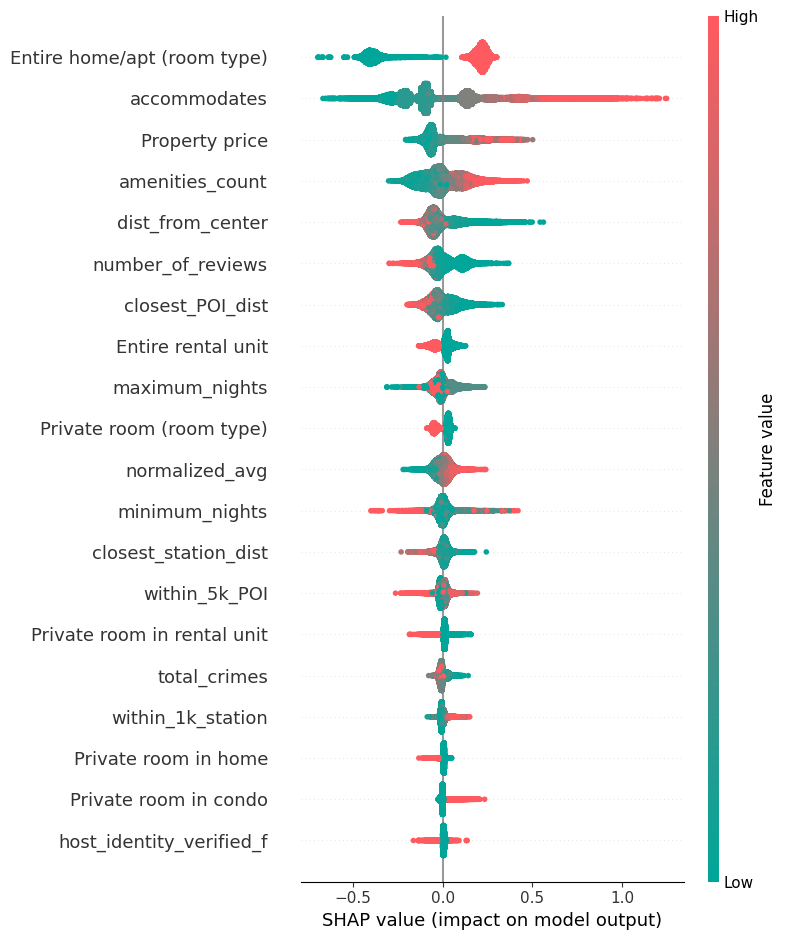

In [ ]:
# Generate colormap through matplotlib
newCmap = LinearSegmentedColormap.from_list("", ['#00A699','#FF5A5F'])

shap.initjs()
shap.summary_plot(shap_values, features = X_train, feature_names = X_train.columns, cmap = newCmap)

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low).

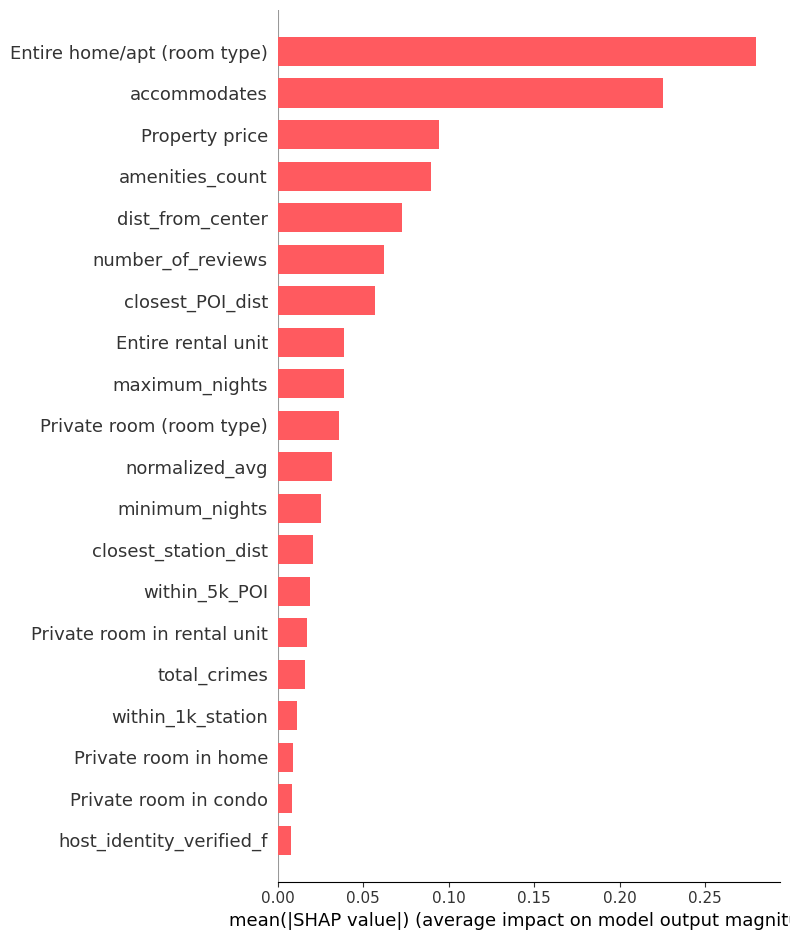

In [ ]:
shap.initjs()
shap.summary_plot(shap_values, features = X_train, feature_names = X_train.columns, plot_type ='bar', color = '#FF5A5F')

We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot

In [4]:
from keras import callbacks,metrics
from sklearn.metrics import r2_score
import keras.backend as K

In [13]:

# Define the deep learning model with increased number of neurons and hidden layers
model = models.Sequential([
    layers.Dense(256, input_shape=(X_train.shape[1],), activation='relu', ),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))
  
# Compile the model with a lower learning rate
opt = optimizers.Adagrad(lr=0.01)
model.compile(optimizer=opt, loss='mse', metrics=['mae', metrics.RootMeanSquaredError(), r_squared])

# Train the model with early stopping
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10)
#model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])


**Deep learning**

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_335 (Dense)           (None, 256)               37120     
                                                                 
 dense_336 (Dense)           (None, 128)               32896     
                                                                 
 dense_337 (Dense)           (None, 128)               16512     
                                                                 
 dense_338 (Dense)           (None, 128)               16512     
                                                                 
 dense_339 (Dense)           (None, 128)               16512     
                                                                 
 dense_340 (Dense)           (None, 64)                8256      
                                                                 
 dense_341 (Dense)           (None, 32)              

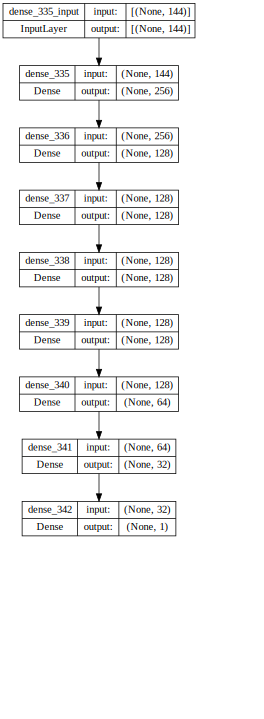

In [14]:
'''
# Building the model
model = models.Sequential()
model.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(layers.Dense(150, activation='relu'))
model.add(layers.Dense(150, activation='relu'))
model.add(layers.Dense(1, activation='relu'))

# Compiling the model
model.compile(loss = 'mean_squared_error',
              optimizer = 'adam',
              metrics = ['mean_squared_error'])
'''

# Printing the model summary
print(model.summary())

# Visualising the neural network
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [15]:
%%time
# Training the deep learning model
X_train_np = np.array(X_train)
X_val_np = np.array(X_val)
y_train_np = np.array(y_train)
y_val_np = np.array(y_val)


history = model.fit(X_train_np , 
                    y_train_np,
                    validation_data=(X_val_np, y_val_np), 
                    callbacks=[early_stop],
                    epochs = 1000,
                    batch_size = 60,
                    verbose = False)

CPU times: user 5min 2s, sys: 12 s, total: 5min 14s
Wall time: 4min 14s


In [16]:
# predict
y_val_pred = model.predict(X_val)
y_train_pred = model.predict(X_train)

# Print RMSE
print("Training RMSE:", np.sqrt(round(mean_squared_error(y_train, y_train_pred),4)))
print("Validation RMSE:",  np.sqrt(round(mean_squared_error(y_val, y_val_pred),4)))

# Print Adjusted R2
r2_training = r2_score(y_train, y_train_pred)
print("\nTraining r2:", r2_training)

r2_validation = r2_score(y_val, y_val_pred)
print("Validation r2:", r2_validation)

1228/1228 [==============================] - 3s 2ms/step
Training RMSE: 0.431161222746202
Validation RMSE: 0.46776062254106

Training r2: 0.6986058253757359
Validation r2: 0.6562516225056145


**Out of Sample (Test set results)**

In [17]:
# predict
prediction = model.predict(X_test)

# Print RMSE
print("Test Set RMSE:",  np.sqrt(round(mean_squared_error(y_test, prediction),4)))

# Print Adjusted R2
r_square = r2_score(y_test, prediction)
print("Test Set r2:", r_square)

154/154 [==============================] - 0s 2ms/step
Test Set RMSE: 0.4517742799230607
Test Set r2: 0.6702465186306757


In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 5.8 MB/s eta 0:00:00


In [12]:
# Trying out Hyper parameter tuning using optuna package

import optuna
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

def objective(trial):
    # Define hyperparameters to tune
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 3, 20)
    num_units = trial.suggest_int('num_units', 16, 256)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
    l2_lambda = trial.suggest_loguniform('l2_lambda', 1e-5, 1e-2)

    # Build the model with the hyperparameters to tune
    model = Sequential()
    model.add(Dense(num_units, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(l2_lambda)))
    for i in range(num_hidden_layers):
        model.add(Dense(num_units, activation='relu', kernel_regularizer=l2(l2_lambda)))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='relu'))

    # Compile the model with the learning rate to tune
    optimizer = Adam(lr=learning_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=[RootMeanSquaredError()])

    # Set up early stopping
    early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5)

    # Train the model
    model.fit(X_train_np, y_train_np, epochs=10, batch_size=32, validation_data=(X_val_np, y_val_np), verbose=0, callbacks=[early_stop])

    # Evaluate the model
    y_pred = model.predict(np.array(X_test))
    r2 = r2_score(y_test, y_pred)

    return r2

# Set up and run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Get the best hyperparameters and their resulting R2 score
best_params = study.best_params
best_r2 = study.best_value
print(f"Best R2 score: {best_r2}")
print(f"Best hyperparameters: {best_params}")

# Train the model with the best hyperparameters and evaluate on the test set
best_model = models.Sequential()
best_model.add(Dense(best_params['num_units'], input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(best_params['l2_lambda'])))
for i in range(best_params['num_hidden_layers']):
    best_model.add(Dense(best_params['num_units'], activation='relu', kernel_regularizer=l2(best_params['l2_lambda'])))
    best_model.add(Dropout(best_params['dropout_rate']))
best_model.add(Dense(1, activation='linear'))

best_optimizer = Adam(lr=best_params['learning_rate'])
best_model.compile(loss='mse', optimizer=best_optimizer, metrics=[RootMeanSquaredError()])

best_model.fit(X_train_np, y_train_np, epochs=10, batch_size=32, validation_data=(X_val_np, y_val_np), verbose=0, callbacks=[early_stop])
y_pred = best_model.predict(np.array(X_test))
best_r2 = r2_score(np.array(y_test), y_pred)
print(f"R2 score on test set:{best_r2}")


[I 2023-04-13 01:46:43,466] A new study created in memory with name: no-name-5747c042-3dbb-45fa-8eb7-5996c1feba4f


154/154 [==============================] - 0s 3ms/step


[I 2023-04-13 01:48:05,292] Trial 0 finished with value: 0.5693666318651067 and parameters: {'learning_rate': 0.006117532317524062, 'num_hidden_layers': 3, 'num_units': 247, 'dropout_rate': 0.44103386139028267, 'l2_lambda': 0.007570337702910877}. Best is trial 0 with value: 0.5693666318651067.


154/154 [==============================] - 1s 2ms/step


[I 2023-04-13 01:49:43,264] Trial 1 finished with value: 0.5028899205409753 and parameters: {'learning_rate': 0.0010896359952267524, 'num_hidden_layers': 17, 'num_units': 68, 'dropout_rate': 0.14610614081667148, 'l2_lambda': 2.0190458715264573e-05}. Best is trial 0 with value: 0.5693666318651067.


154/154 [==============================] - 1s 2ms/step


[I 2023-04-13 01:53:07,625] Trial 2 finished with value: 0.5865606866115081 and parameters: {'learning_rate': 0.002926833652738138, 'num_hidden_layers': 11, 'num_units': 191, 'dropout_rate': 0.3098527052683968, 'l2_lambda': 0.0016644151659379388}. Best is trial 2 with value: 0.5865606866115081.


154/154 [==============================] - 2s 9ms/step


[I 2023-04-13 02:00:35,422] Trial 3 finished with value: 0.6474091441029111 and parameters: {'learning_rate': 0.0002573978246257208, 'num_hidden_layers': 18, 'num_units': 246, 'dropout_rate': 0.1308174992454129, 'l2_lambda': 0.00023267402109332965}. Best is trial 3 with value: 0.6474091441029111.


154/154 [==============================] - 1s 5ms/step


[I 2023-04-13 02:06:01,642] Trial 4 finished with value: 0.5184172145149468 and parameters: {'learning_rate': 0.00010095546229092036, 'num_hidden_layers': 12, 'num_units': 250, 'dropout_rate': 0.3098663420518844, 'l2_lambda': 0.000426772051536737}. Best is trial 3 with value: 0.6474091441029111.


154/154 [==============================] - 0s 2ms/step


[I 2023-04-13 02:06:48,098] Trial 5 finished with value: 0.3029743660406432 and parameters: {'learning_rate': 7.897977960698866e-05, 'num_hidden_layers': 6, 'num_units': 31, 'dropout_rate': 0.25403363724316513, 'l2_lambda': 0.0002704061267009669}. Best is trial 3 with value: 0.6474091441029111.


154/154 [==============================] - 0s 2ms/step


[I 2023-04-13 02:08:11,682] Trial 6 finished with value: 0.6397875848056225 and parameters: {'learning_rate': 0.0015935735718718372, 'num_hidden_layers': 3, 'num_units': 108, 'dropout_rate': 0.14158177520257886, 'l2_lambda': 0.004232302504720614}. Best is trial 3 with value: 0.6474091441029111.


154/154 [==============================] - 1s 3ms/step


[I 2023-04-13 02:10:34,875] Trial 7 finished with value: 0.6460314593507319 and parameters: {'learning_rate': 0.002382916784650538, 'num_hidden_layers': 19, 'num_units': 104, 'dropout_rate': 0.11785250142333999, 'l2_lambda': 4.633135180757154e-05}. Best is trial 3 with value: 0.6474091441029111.


154/154 [==============================] - 0s 2ms/step


[I 2023-04-13 02:12:00,917] Trial 8 finished with value: 0.490387933438458 and parameters: {'learning_rate': 0.0013897907537719668, 'num_hidden_layers': 17, 'num_units': 42, 'dropout_rate': 0.1386250789379122, 'l2_lambda': 9.776195201833647e-05}. Best is trial 3 with value: 0.6474091441029111.


154/154 [==============================] - 1s 2ms/step


[I 2023-04-13 02:13:13,976] Trial 9 finished with value: 0.5455233200701769 and parameters: {'learning_rate': 0.0010624687284387648, 'num_hidden_layers': 7, 'num_units': 95, 'dropout_rate': 0.45891921181208684, 'l2_lambda': 0.00967919562504443}. Best is trial 3 with value: 0.6474091441029111.


154/154 [==============================] - 1s 3ms/step


[I 2023-04-13 02:15:39,650] Trial 10 finished with value: -1.1733330442204943 and parameters: {'learning_rate': 1.6192330177468374e-05, 'num_hidden_layers': 13, 'num_units': 176, 'dropout_rate': 0.22095602267444778, 'l2_lambda': 1.1383217791538369e-05}. Best is trial 3 with value: 0.6474091441029111.


154/154 [==============================] - 1s 3ms/step


[I 2023-04-13 02:19:19,295] Trial 11 finished with value: 0.5795003249179584 and parameters: {'learning_rate': 0.00034229780543007694, 'num_hidden_layers': 20, 'num_units': 151, 'dropout_rate': 0.10064403581533111, 'l2_lambda': 4.8498745707825434e-05}. Best is trial 3 with value: 0.6474091441029111.


154/154 [==============================] - 1s 3ms/step


[I 2023-04-13 02:23:45,878] Trial 12 finished with value: -0.012415029691741353 and parameters: {'learning_rate': 0.007379717554624489, 'num_hidden_layers': 20, 'num_units': 208, 'dropout_rate': 0.18388629085735445, 'l2_lambda': 9.54859856246568e-05}. Best is trial 3 with value: 0.6474091441029111.


154/154 [==============================] - 1s 2ms/step


[I 2023-04-13 02:27:10,997] Trial 13 finished with value: 0.6355465030711352 and parameters: {'learning_rate': 0.0004199964826883617, 'num_hidden_layers': 16, 'num_units': 133, 'dropout_rate': 0.11172516454141412, 'l2_lambda': 0.00033080288259306856}. Best is trial 3 with value: 0.6474091441029111.


154/154 [==============================] - 0s 2ms/step


[I 2023-04-13 02:29:23,646] Trial 14 finished with value: 0.5527527960597423 and parameters: {'learning_rate': 0.0005704873123746666, 'num_hidden_layers': 15, 'num_units': 107, 'dropout_rate': 0.19569501057188948, 'l2_lambda': 2.9562412725922617e-05}. Best is trial 3 with value: 0.6474091441029111.


154/154 [==============================] - 1s 3ms/step


[I 2023-04-13 02:33:49,429] Trial 15 finished with value: 0.36867398382751204 and parameters: {'learning_rate': 0.00014336960743989668, 'num_hidden_layers': 19, 'num_units': 149, 'dropout_rate': 0.25120546667719207, 'l2_lambda': 8.931299686531664e-05}. Best is trial 3 with value: 0.6474091441029111.


154/154 [==============================] - 1s 4ms/step


[I 2023-04-13 02:39:00,683] Trial 16 finished with value: -0.032073966050949254 and parameters: {'learning_rate': 0.004462793225182926, 'num_hidden_layers': 18, 'num_units': 222, 'dropout_rate': 0.17458701741399354, 'l2_lambda': 0.00018823581200571728}. Best is trial 3 with value: 0.6474091441029111.


154/154 [==============================] - 0s 2ms/step


[I 2023-04-13 02:41:25,776] Trial 17 finished with value: 0.5988617123477786 and parameters: {'learning_rate': 0.0025230868271925834, 'num_hidden_layers': 14, 'num_units': 74, 'dropout_rate': 0.1078907457217291, 'l2_lambda': 0.0010208254382774594}. Best is trial 3 with value: 0.6474091441029111.


154/154 [==============================] - 0s 2ms/step


[I 2023-04-13 02:43:41,547] Trial 18 finished with value: -0.004520976804732291 and parameters: {'learning_rate': 0.00983331680660634, 'num_hidden_layers': 10, 'num_units': 175, 'dropout_rate': 0.2190807349783491, 'l2_lambda': 5.6527176548090806e-05}. Best is trial 3 with value: 0.6474091441029111.


154/154 [==============================] - 0s 2ms/step


[I 2023-04-13 02:45:00,326] Trial 19 finished with value: 0.2462339180898233 and parameters: {'learning_rate': 0.0001928186227462255, 'num_hidden_layers': 9, 'num_units': 77, 'dropout_rate': 0.1557591861507602, 'l2_lambda': 0.00019062360552788316}. Best is trial 3 with value: 0.6474091441029111.


Best R2 score: 0.6474091441029111
Best hyperparameters: {'learning_rate': 0.0002573978246257208, 'num_hidden_layers': 18, 'num_units': 246, 'dropout_rate': 0.1308174992454129, 'l2_lambda': 0.00023267402109332965}
154/154 [==============================] - 1s 7ms/step
R2 score on test set:0.6059596944570687
